# Decision Trees

## Training and Visualizing a Decision Tree

In [1]:
from sklearn.datasets import load_iris

from sklearn.tree import DecisionTreeClassifier

In [2]:
iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.4, 0.8333333333333334, 'petal length (cm) <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]')]

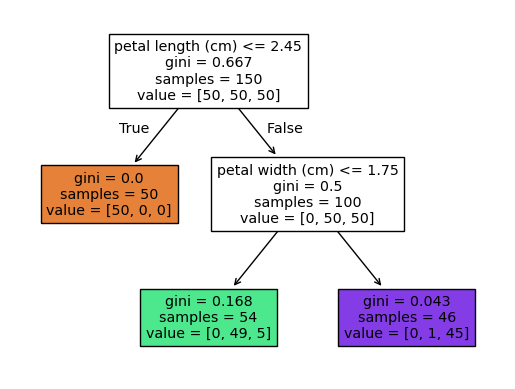

In [3]:
from sklearn.tree import plot_tree

plot_tree(tree_clf, filled=True, feature_names=["petal length (cm)", "petal width (cm)"])

- `samples` attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm, and of those 100, 54 have a petal width smaller than 1.75cm.

- `value` attribute tells you how many training instances of each class this node applies to. For example, the bottom-right node applies to 0 Iris setosa, 1 Iris versicolor and 45 Iris Virginica.

- `gini` attribute measures its impurity: a node is "pure" (`gini`=0) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies to only Iris setosa training instances, it is pure and its `gini` is 0

***Gini impurity***

$$
G_{í}=1-\sum_{k=1}^{n}p_{i,k}^{2}
$$

Where:
- $p_{i,k}$ is the ration of class $k$ instances among the training instances in the $i^{th}$ node.

The depth-2 left node has a `gini` score equal to:
$$
1 - (\frac{0}{54})^2-(\frac{49}{54})^2-(\frac{5}{54})^2\approx 0.168
$$

## Making Predictions

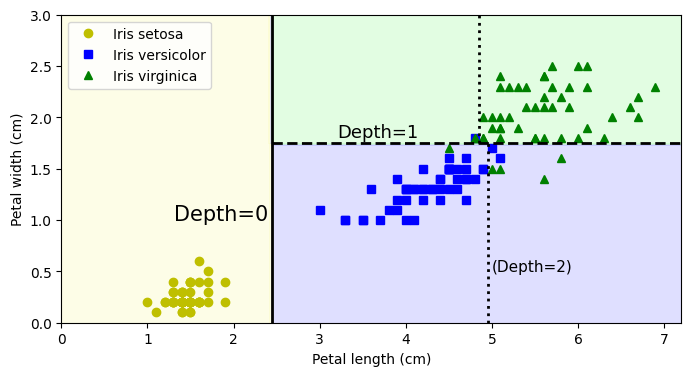

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
	plt.plot(X[:, 0][y == idx], X[:, 1][y == idx], style, label=f"Iris {name}")

tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X, y)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]

plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

### Model Interpretation: While Box vs Black Box

Decision Trees are intuitive, and their decisions are easy to interpret. Such models are often called ***White Box*** models. In contrast, as we will see, Random Forests or Neural Networks are generally considered ***Black Box*** models. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. For example, if a neural network says that a particular person appears on a picture, it is hard to know what contributed to this prediction: did the model recognize that person's eye? Their mouth? Their nose or shoes. Conversely, Decision Trees provide nice, simple classification rules that can even be applied manually if need be

## Estimating Class Probabilities

For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the Decision Tree should output the following probabilities:
- $0$% for Iris setosa $\frac{0}{54}$
- $90.7$% for Iris versicolor $\frac{49}{54}$
- $9.3$% for Iris virginica $\frac{5}{54}$

And if you ask it to predict the class, it outputs Iris versicolor because it has the highest probability

In [5]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorith

Scikit-Learn uses *The Classification and Regression Tree* (CART) algorithm to train Decision Trees (also called "growing" trees). The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_{k}$ (e.g. "petal length $\leq 2.45$ cm"). How does it choose $k$ and $t_k$? It searches for the pair $(k,t_k)$ that produces the purest subsets

***CART cost function for classification***

\begin{aligned}
&J\left(k, t_k\right)=\frac{m_{\text {left }}}{m} G_{\text {left }}+\frac{m_{\text {right }}}{m} G_{\text {right }}\\
&\text { where }\left\{\begin{array}{l}
G_{\text {left/right }} \text { measures the impurity of the left/right subset, } \\
m_{\text {left/right }} \text { is the number of instances in the left/right subset. }
\end{array}\right.
\end{aligned}

Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by `max_depth`), or it cannot find a split that will reduce impurity. A few other hyperparameters controls additional stopping conditions (`min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, and `max_leaf_nodes`).

## Computational Complexity

Decision Trees generally are approximately balances, so traversing the Decision Tree requires going through roughly $O(log_{2}(m))$ nodes. Since each node only requires checking the value of one feature, the overall prediction complexity is $O(log_{2}(m))$, independent of the number of features.

The training algorithm compares all features (or less if `max_features` is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of $O(n \times m log_{2}(m))$.
For small training sets, Scikit-Learn can speed up training by presorting the data (set `presort=True`), but doing that slows down training considerably for larger training sets.

## Gini Impurity or Entropy

By default, The Gini impurity measure is used, but you can select the *entropy* impurity measure instead by setting the `criterion` hyperparameter to "entropy".

***Entropy***:
$$
H_i=-\sum_{\substack{k=1 \\ p_{i, k} \neq 0}}^n p_{i, k} \log _2\left(p_{i, k}\right)
$$

For example, the depth-2 left node had an entropy equal to $-(49/54)log_2(49/54) - (5/54)log_{2}(5/54)\approx 0.445$


So **Gini** or **Entropy**?. In most of the cases it doesn't make a big difference: they lead to similar trees. **Gini** impurity is slightly faster to compute, so it is a good default. However. when they differ, **Gini** tends to isolate the most frequent class in its own branch of the tree, while **Entropy** tends to produce slightly more balanced trees

## Regularization Hyperparameters

If Decision Tree is left unconstrained , it will adapt itself to the training data, fitting it very closely - indeed, most likely overfitting it. Such a model is often called a ***Nonparametric*** model not because it doesn't have any parameters but because the number of parameters is not determined prior to training. In contrast, a ***Parametric Model***, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting

Possible hyperparameters to tune in order to avoid overfitting (regularization):
- `max_depth`: The depth of the Decision tree
- `min_samples_split`: The minimum number of samples a node must have before it can be split
- `min_samples_leaf`: The minimum number of samples a leaf node must have
- `min_weight_factor_leaf`: Same as above but expressed as a fraction of the total number of weighted instances
- `max_leaf_node`: The maximum number of leaf nodes
- `max_features`: The maximum number of features that are evaluated for splitting at each node

Increasing `min_*` and reducing `max_*` hyperparameters will regularize the model

In [7]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [8]:
def plot_decision_boundary(clf, X, y, axes, cmap):
	x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
						 np.linspace(axes[2], axes[3], 100))
	X_new = np.c_[x1.ravel(), x2.ravel()]
	y_pred = clf.predict(X_new).reshape(x1.shape)

	plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
	plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
	colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}

	markers = ("o", "^")
	for idx in (0, 1):
		plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
				 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
	plt.axis(axes)
	plt.xlabel(r"$x_1$")
	plt.ylabel(r"$x_2$", rotation=0)

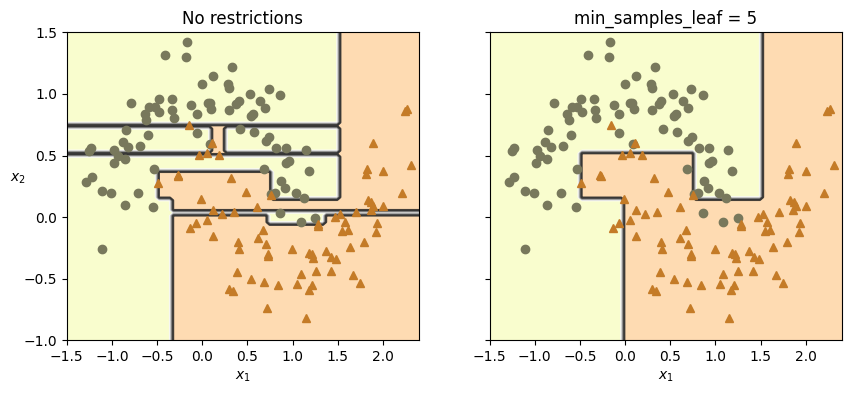

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
					   axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
					   axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

In [10]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [11]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92